In [2]:
!pip install distance
!pip install fuzzywuzzy

     |████████████████████████████████| 184kB 8.1MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp37-none-any.whl size=16261 sha256=7601472fac4b81a4c351a3bea6c02cccc637fa9fee1b0ed7bd6b22b777d792a4
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import distance
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Project/train.csv.zip')
df.head(8)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


36.92 % duplicated question pairs.
63.08 % non duplicated question pairs.


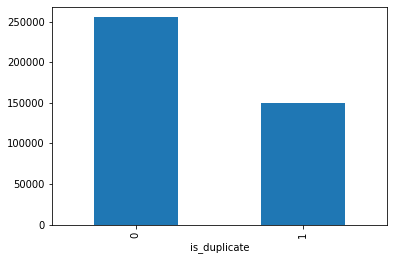

In [6]:
print( round(df['is_duplicate'].mean()*100, 2),"% duplicated question pairs.")
print(100- round(df['is_duplicate'].mean()*100, 2),"% non duplicated question pairs.")
df.groupby("is_duplicate")['id'].count().plot.bar()

In [7]:
df = df.fillna('')

## Feature Enginerring 

 - ___q1len___ = Length of q1
 - ___q2len___ = Length of q2
 - ___diff_len___ = len(q1)-len(q2)       


 - ___q1_n_words___ = Number of words in q1
 - ___q2_n_words___ = Number of words in q2
 - ___diff_n_words___ = The difference       


 - ___caps_count_q1___ = Number of capital words of q1
 - ___caps_count_q2___ = Number of capital words of q2
 - ___diff_caps___ = The difference       


 - ___len_char_q1___ = Number of characters of q1
 - ___len_char_q2___ = Number of characters of q2
 - ___diff_len_char___ = The difference      


 - ___avg_word_len1___ = len(char)/len(word) of q1
 - ___avg_word_len2___ = len(char)/len(word) of q2
 - ___diff_avg_word___ = The difference      


 - ___word_Common___ = Number of common unique words in q1 and q2
 - ___word_Total___ = Total num of words in Question 1 + Total num of words in q2
 - ___word_share___ = (word_common)/(word_Total)    
 - ___2_gram_share___ = word share on 2 gram


 - ___exactly_same___ = exactly the same



In [8]:
if os.path.isfile('/content/drive/MyDrive/Project/feature_tm.csv'):
  df = pd.read_csv('/content/drive/MyDrive/Project/feature_tm.csv',encoding='latin-1')
else:
  df['q1len'] = df.question1.str.len()
  df['q2len'] = df.question2.str.len()
  df['diff_len'] = df.q1len - df.q2len
  
  df['len_word_q1'] = df.question1.apply(lambda row: len(row.split(" ")))
  df['len_word_q2'] = df.question2.apply(lambda row: len(row.split(" ")))
  df['diff_words'] = df.len_word_q1 - df.len_word_q2
  
  df['caps_count_q1'] = df.question1.apply(lambda x:sum(1 for i in str(x) if i.isupper()))
  df['caps_count_q2'] = df.question2.apply(lambda x:sum(1 for i in str(x) if i.isupper()))
  df['diff_caps'] = df.caps_count_q1 - df.caps_count_q2
  
  df['len_char_q1'] = df.question1.apply(lambda x: len(str(x).replace(' ', '')))
  df['len_char_q2'] = df.question2.apply(lambda x: len(str(x).replace(' ', '')))
  df['diff_len_char'] = df.len_char_q1 - df.len_char_q2
  
  df['avg_world_len1'] = df.len_char_q1 / df.len_word_q1
  df['avg_world_len2'] = df.len_char_q2 / df.len_word_q2
  df['diff_avg_word'] = df.avg_world_len1 - df.avg_world_len2

  def word_common(row):
      w1 = set(map(lambda word: word.lower().strip(), row.question1.split(" ")))
      w2 = set(map(lambda word: word.lower().strip(), row.question2.split(" ")))    
      return 1.0 * len(w1 & w2)

  def word_total(row):
      w1 = set(map(lambda word: word.lower().strip(), row.question1.split(" ")))
      w2 = set(map(lambda word: word.lower().strip(), row.question2.split(" ")))    
      return 1.0 * (len(w1) + len(w2))

  def word_share(row):
      w1 = set(map(lambda word: word.lower().strip(), row.question1.split(" ")))
      w2 = set(map(lambda word: word.lower().strip(), row.question2.split(" ")))    
      return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

  def get_2_gram_share(row):
      q1_list = str(row.question1).lower().split()
      q2_list = str(row.question2).lower().split()
      q1_2_gram = set([i for i in zip(q1_list, q1_list[1:])])
      q2_2_gram = set([i for i in zip(q2_list, q2_list[1:])])
      shared_2_gram = q1_2_gram.intersection(q2_2_gram)
      if len(q1_2_gram) + len(q2_2_gram) == 0:
          R2gram = 0
      else:
          R2gram = len(shared_2_gram) / (len(q1_2_gram) + len(q2_2_gram))
      return R2gram

  df['word_Common'] = df.apply(word_common, axis=1)
  df['word_Total'] = df.apply(word_total, axis=1)
  df['word_share'] = df.apply(word_share, axis=1)
  df['share_2_gram'] = df.apply(get_2_gram_share, axis=1) 

  df.to_csv('/content/drive/MyDrive/Project/feature_tm.csv', index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,diff_len,len_word_q1,len_word_q2,diff_words,caps_count_q1,caps_count_q2,diff_caps,len_char_q1,len_char_q2,diff_len_char,avg_world_len1,avg_world_len2,diff_avg_word,word_Common,word_Total,word_share,share_2_gram
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,14,12,2,1,1,0,53,46,7,3.785714,3.833333,-0.047619,10.0,23.0,0.434783,0.416667
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,8,13,-5,5,5,0,44,76,-32,5.500000,5.846154,-0.346154,4.0,20.0,0.200000,0.052632
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,14,10,4,5,5,0,60,50,10,4.285714,5.000000,-0.714286,4.0,24.0,0.166667,0.045455
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,11,9,2,4,1,3,40,57,-17,3.636364,6.333333,-2.696970,0.0,19.0,0.000000,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,13,7,6,1,1,0,64,33,31,4.923077,4.714286,0.208791,2.0,20.0,0.100000,0.000000


## Feature Engineering on NLP Features
- __last_word_eq__ :  Check if Last word of both questions is equal or not<br>


- __first_word_eq__ :  Check if First word of both questions is equal or not<br>


- __abs_len_diff__ :  Abs. length difference<br>


- __mean_len__ :  Average Token Length of both Questions<br>

- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>


- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>

- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br>


- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>

- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>


- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>

- __wmd_dist__:
- __cosine_dist__

- __cityblock_dist__


- __canberra_dist__

- __euclidean_dist__


- __minkowski_dist__


- __fuzz_ratio__ 

- __fuzz_partial_ratio__


- __token_sort_ratio__


- __token_set_ratio__ 


- __longest_substr_ratio__ 

In [9]:
import nltk
nltk.download('stopwords')

SAFE_DIV = 0.0001 

from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x


In [11]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

In [12]:
glove2word2vec(glove_input_file="/content/drive/MyDrive/Project/glove.840B.300d.txt", word2vec_output_file="glove_vectors.txt")
glove_model = KeyedVectors.load_word2vec_format("glove_vectors.txt", binary=False)

In [13]:
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, canberra, euclidean, minkowski

In [14]:
def remove_stop(sentence):
    sentence  = str(sentence)
    if sentence == None:
        return ' '
    if sentence == np.nan:
        return ' '
    if sentence == 'NaN':
        return ' '
    z = [i for i in sentence.split() if i not in STOP_WORDS]
    return ' '.join(z)
  
def wmd(s1, s2, model):
    s1 = str(s1)
    s2 = str(s2)
    s1 = s1.split()
    s2 = s2.split()
    return model.wmdistance(s1, s2)

def g2w2v(list_of_sent, model, d):
    sent_vectors = []
    for sentence in list_of_sent: 
        doc = [word for word in sentence if word in model.wv.vocab] 
        if doc:
            sent_vec = np.mean(model.wv[doc],axis=0) 
        else:
            sent_vec = np.zeros(d)
        sent_vectors.append(sent_vec)
    return sent_vectors

def get_distance_features(df):
    
    print("Extracting Distance Features..")
    
    df['question1'] = df.question1.apply(remove_stop)
    df['question2'] = df.question2.apply(remove_stop)
    df['word_mover_dist'] = df.apply(lambda x: wmd(x['question1'], x['question2'],glove_model), axis=1)
    
    print("- wmd done...")
    
    list_of_question1=[]
    for sentence in df.question1.values:
        list_of_question1.append(sentence.split())
    
    list_of_question2=[]
    for sentence in df.question2.values:
        list_of_question2.append(sentence.split())
    
    g2w2v_q1 = g2w2v(list_of_question1, glove_model, 300)
    g2w2v_q2 = g2w2v(list_of_question2, glove_model, 300)
    
    print("- embedding done...")
    
    df['cosine_dist'] = [cosine(q1, q2) for (q1, q2) in zip(g2w2v_q1,g2w2v_q2)]
    df['cityblock_dist'] = [cityblock(q1, q2) for (q1, q2) in zip(g2w2v_q1,g2w2v_q2)]
    df['canberra_dist'] = [canberra(q1, q2) for (q1, q2) in zip(g2w2v_q1,g2w2v_q2)]
    df['euclidean_dist'] = [euclidean(q1, q2) for (q1, q2) in zip(g2w2v_q1,g2w2v_q2)]
    df['minkowski_dist'] = [minkowski(q1, q2) for (q1, q2) in zip(g2w2v_q1,g2w2v_q2)]
    
    print('- spatial distance done')
    
    df.cosine_dist = df.cosine_dist.fillna(0)
    df.word_mover_dist = df.word_mover_dist.apply(lambda wmd: 30 if wmd == np.inf else wmd )
   
    return df

In [15]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    common_word_count = len(q1_words.intersection(q2_words))
    
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features


def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [16]:
def extract_features(df):
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("Extracting Token Features...")
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    print("Extracting Fuzzy Features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [18]:
if os.path.isfile('feature_nlp.csv'):
    df_nlp = pd.read_csv("feature_nlp.csv",encoding='latin-1')
else:
    print("Extracting features for train:")
    df = pd.read_csv("/content/drive/MyDrive/Project/train.csv.zip")
    df = extract_features(df)
    df = get_distance_features(df)
    df = df.drop(['qid1','qid2','question1','question2','is_duplicate'], axis=1)
    df.to_csv("feature_nlp.csv", index=False)
df.head()

Extracting features for train:
Extracting Token Features...
Extracting Fuzzy Features..
Extracting Distance Features..
- wmd done...
- embedding done...
- spatial distance done


,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,word_mover_dist,cosine_dist,cityblock_dist,canberra_dist,euclidean_dist,minkowski_dist
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1.216034,0.031762,14.274065,91.483062,1.047253,1.047253
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4.897662,0.266555,33.272633,149.670092,2.624989,2.624989
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,4.011556,0.118900,28.457512,129.214660,2.140298,2.140298
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,7.514702,0.619671,62.016426,200.899534,4.702347,4.702347
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,6.257260,0.244168,40.127296,156.627744,3.145122,3.145122
